# Importing modules

In [78]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from nca_implementation.torchnca import nca
import matplotlib.pyplot as plt
import numpy as np

# Loading data

In [79]:
# Read pickles
df_m67 = pd.read_pickle('./data/oc_Messier_67_candidates.pickle')
df_m44 = pd.read_pickle('./data/oc_Messier_44_candidates.pickle')

# Filter based on fidelity_v2 >= 0.7
df_m67 = df_m67[df_m67['fidelity_v2'] >= 0.7]
df_m44 = df_m44[df_m44['fidelity_v2'] >= 0.7]

# Select only relevant columns
SELECTED_COLS = ['ra', 'dec', 'pmra', 'pmdec', 'r_med_geo', 'fidelity_v2', 'cluster_flag'] 
df_m67 = df_m67[SELECTED_COLS]
df_m44 = df_m44[SELECTED_COLS]

# Set cluster candidate information
"""
0 - M67_NOCLUSTER
1 - M67_CLUSTER
2 - M44_NOCLUSTER
3 - M44_CLUSTER
"""
df_m67.loc[df_m67.cluster_flag == 0, 'cluster_flag'] = 0
df_m67.loc[df_m67.cluster_flag == 1, 'cluster_flag'] = 1

df_m44.loc[df_m44.cluster_flag == 0, 'cluster_flag'] = 2
df_m44.loc[df_m44.cluster_flag == 1, 'cluster_flag'] = 3

# Join the data
df = pd.concat([df_m67, df_m44])

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: >]], dtype=object)

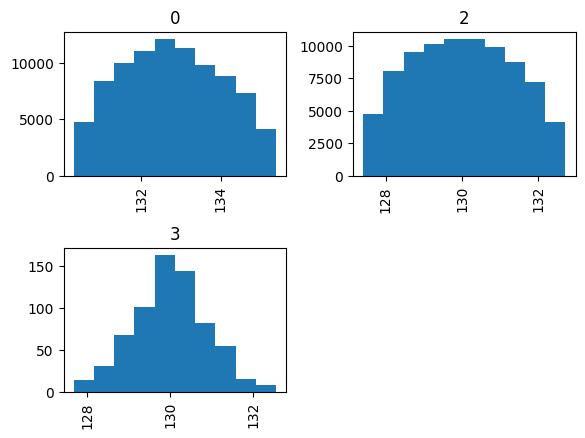

In [80]:
df['ra'].hist(by=df['cluster_flag'])

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: >]], dtype=object)

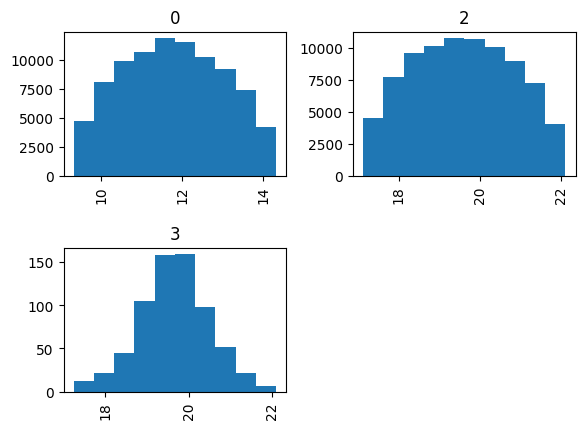

In [81]:
df['dec'].hist(by=df['cluster_flag'])

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: >]], dtype=object)

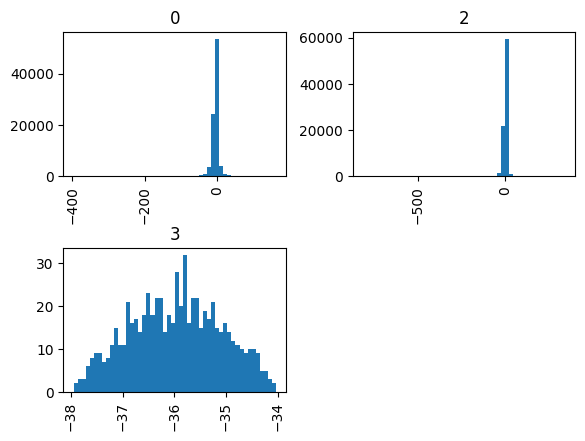

In [82]:
df['pmra'].hist(by=df['cluster_flag'], bins=50)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: >]], dtype=object)

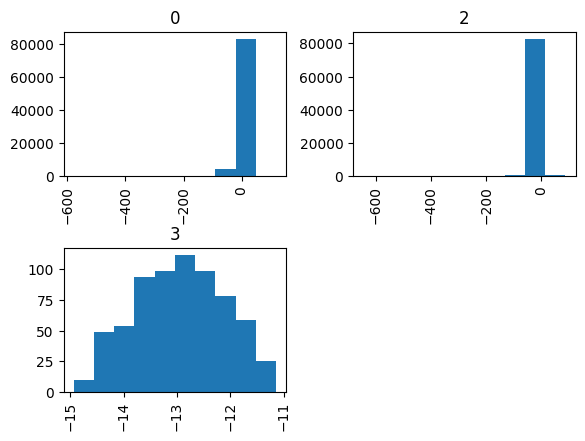

In [83]:
df['pmdec'].hist(by=df['cluster_flag'])

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: >]], dtype=object)

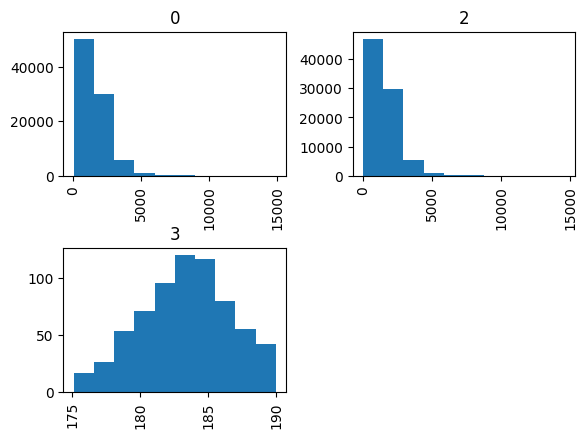

In [84]:
df['r_med_geo'].hist(by=df['cluster_flag'])

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: >]], dtype=object)

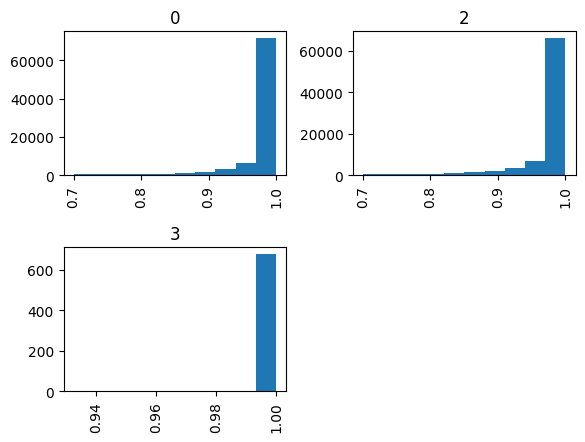

In [85]:
df['fidelity_v2'].hist(by=df['cluster_flag'])

In [86]:
print("-------- COLUMN INFORMATION --------")
df.info()

-------- COLUMN INFORMATION --------
<class 'pandas.core.frame.DataFrame'>
Index: 171955 entries, 1 to 110831
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ra            171955 non-null  float64
 1   dec           171955 non-null  float64
 2   pmra          171955 non-null  float64
 3   pmdec         171955 non-null  float64
 4   r_med_geo     171955 non-null  float32
 5   fidelity_v2   171955 non-null  float32
 6   cluster_flag  171955 non-null  int64  
dtypes: float32(2), float64(4), int64(1)
memory usage: 9.2 MB


In [87]:
print("-------- CLUSTER CANDIDATE INFORMATION --------")
print(df['cluster_flag'].value_counts())

-------- CLUSTER CANDIDATE INFORMATION --------
cluster_flag
0    87711
2    83565
3      679
Name: count, dtype: int64


In [114]:
df.head()

,ra,dec,pmra,pmdec,r_med_geo,fidelity_v2,cluster_flag
1,132.460820,9.354456,-4.467221,11.077062,1299.076538,0.989258,0
2,132.447898,9.347820,-20.515164,5.789698,259.710754,1.000000,0
3,132.422902,9.353250,-11.516026,-1.922608,538.822510,0.993164,0
4,132.399934,9.357089,-5.521866,-9.747638,1644.195190,0.965820,0
5,132.413950,9.358508,-2.926452,5.010006,844.427246,0.966797,0


# Train-test split

In [148]:
# Splitting into features (X) and labels (y)
X = torch.tensor(df.drop(labels=['cluster_flag'], axis=1).values, dtype=torch.float32)
y = torch.tensor(df['cluster_flag'].copy().values)

poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)

X = torch.tensor(poly.fit_transform(X), dtype=torch.float32)
print(X[0])

# Stratified Train-test split (based on labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Move data to GPU
X_train_GPU = X_train.cuda()
X_test_GPU = X_test.cuda()
y_train_GPU = y_train.cuda()
y_test_GPU = y_test.cuda()

tensor([ 1.3246e+02,  9.3545e+00, -4.4672e+00,  1.1077e+01,  1.2991e+03,
         9.8926e-01,  1.2391e+03, -5.9173e+02,  1.4673e+03,  1.7208e+05,
         1.3104e+02, -4.1788e+01,  1.0362e+02,  1.2152e+04,  9.2540e+00,
        -4.9484e+01, -5.8033e+03, -4.4192e+00,  1.4390e+04,  1.0958e+01,
         1.2851e+03])


In [149]:
print(X_train_GPU.shape, y_train_GPU.shape, X_test_GPU.shape, y_test_GPU.shape)

torch.Size([137564, 21]) torch.Size([137564]) torch.Size([34391, 21]) torch.Size([34391])


In [150]:
print("-------- TRAIN DATASET LABEL PERCENTAGES --------")
y_train_uniques, y_train_unique_counts = y_train.unique(return_counts=True)
y_train_total = torch.sum(y_train_unique_counts).item()

for item, count in zip(y_train_uniques, y_train_unique_counts):
    print(f"{item}: {(count / y_train_total) * 100:.4f}%")

print("Total Samples: " + str(y_train_total))

print()

print("-------- TEST DATASET LABEL PERCENTAGES --------")
y_test_uniques, y_test_unique_counts = y_test.unique(return_counts=True)
y_test_total = torch.sum(y_test_unique_counts).item()

for item, count in zip(y_test_uniques, y_test_unique_counts):
    print(f"{item}: {(count / y_test_total) * 100:.4f}%")

print("Total Samples: " + str(y_test_total))

-------- TRAIN DATASET LABEL PERCENTAGES --------
0: 51.0083%
2: 48.5970%
3: 0.3947%
Total Samples: 137564

-------- TEST DATASET LABEL PERCENTAGES --------
0: 51.0075%
2: 48.5970%
3: 0.3955%
Total Samples: 34391


In [181]:
nca_pipeline = nca.NCA(dim=2, max_iters=50)
nca_pipeline.train(X_train_GPU, y_train_GPU, batch_size=32, lr=1e-6)

using random init
epoch: 1 - loss: 40.17504
epoch: 1 - loss: 34.26496
epoch: 1 - loss: 37.90355
epoch: 1 - loss: 36.26991
epoch: 1 - loss: 36.96284
epoch: 1 - loss: 33.88152
epoch: 1 - loss: 31.84695
epoch: 1 - loss: 26.87191
epoch: 1 - loss: 26.69540
epoch: 1 - loss: 22.26602
epoch: 1 - loss: 17.66195
epoch: 1 - loss: 16.85818
epoch: 1 - loss: 13.28280
epoch: 1 - loss: 11.25098
epoch: 1 - loss: 9.08544
epoch: 1 - loss: 8.61238
epoch: 1 - loss: 7.41535
epoch: 1 - loss: 8.90461
epoch: 1 - loss: 6.40123
epoch: 1 - loss: 5.59986
epoch: 1 - loss: 3.64207
epoch: 1 - loss: 8.15818
epoch: 1 - loss: 3.70050
epoch: 1 - loss: 5.53222
epoch: 1 - loss: 3.53166
epoch: 1 - loss: 5.31796
epoch: 1 - loss: 5.45716
epoch: 1 - loss: 3.15664
epoch: 1 - loss: 4.64951
epoch: 1 - loss: 3.78391
epoch: 1 - loss: 4.87683
epoch: 1 - loss: 3.37206
epoch: 1 - loss: 3.34930
epoch: 1 - loss: 3.21534
epoch: 1 - loss: 5.39201
epoch: 1 - loss: 5.05677
epoch: 1 - loss: 3.66280
epoch: 1 - loss: 2.12783
epoch: 1 - loss: 3

In [182]:
nca_pipeline.A.shape

torch.Size([2, 21])

Parameter containing:
tensor([[-0.1665,  0.2689,  0.0118,  0.0052, -0.0128, -0.0067,  0.2699,  0.0123,
          0.0063, -0.0161, -0.0522, -0.0026, -0.0259,  0.0796,  0.2622,  0.0087,
          0.0067,  0.0118, -0.0010,  0.0056, -0.0130],
        [-0.1232,  0.2004, -0.0082,  0.0039, -0.0214,  0.0051,  0.2012, -0.0073,
          0.0047, -0.0236, -0.0293, -0.0326, -0.0220,  0.0427,  0.1978, -0.0155,
          0.0044, -0.0083,  0.0043,  0.0039, -0.0212]], device='cuda:0',
       requires_grad=True)


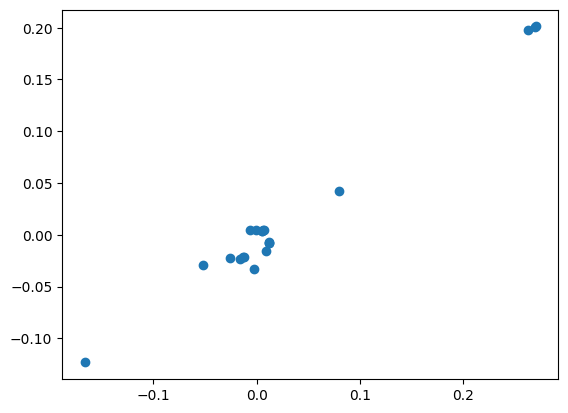

In [183]:
nca_pipeline.A

print(nca_pipeline.A)

plt.scatter(nca_pipeline.A.detach().cpu().numpy()[0], nca_pipeline.A.detach().cpu().numpy()[1])

In [184]:
# Transform the datasets
X_train_transformed = nca_pipeline(X_train_GPU)
X_test_transformed = nca_pipeline(X_test_GPU)

# Move the datasets back to CPU
X_train_transformed = X_train_transformed.detach().cpu().numpy()
X_test_transformed = X_test_transformed.detach().cpu().numpy()
y_train = y_train_GPU.detach().cpu().numpy()
y_test = y_test_GPU.detach().cpu().numpy()

print(X_train_transformed.shape, X_test_transformed.shape)

(137564, 2) (34391, 2)


(137564, 2)


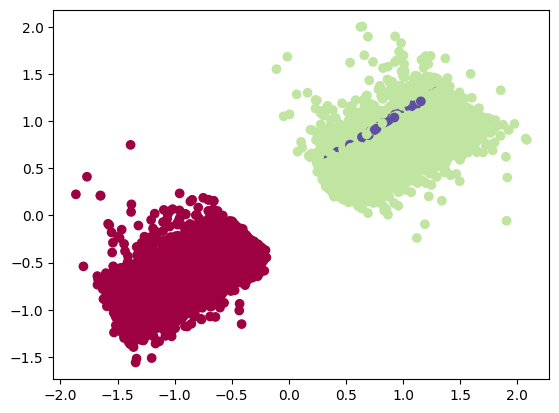

In [185]:
n_train, n_test = X_train_transformed.shape[0], X_test_transformed.shape[0]

print(X_train_transformed.shape)

plt.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], c=y_train, cmap=plt.cm.Spectral)

(543, 2)


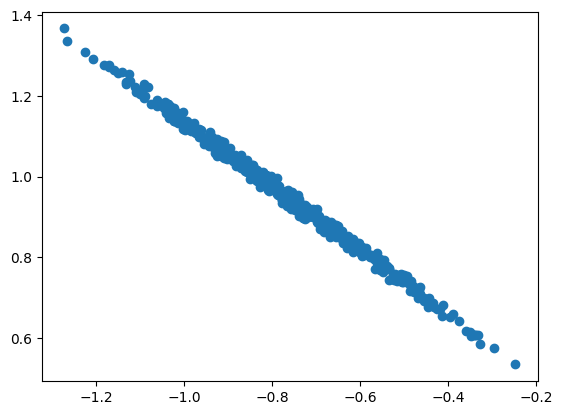

In [178]:
blah_X = X_train_transformed[y_train == 3]
blah_y = y_train[y_train == 3]

print(blah_X.shape)

plt.scatter(blah_X[:, 0], blah_X[:, 1])

(66852, 2)


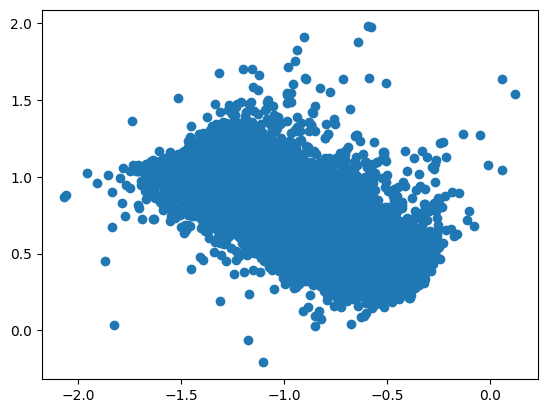

In [179]:
yo_X = X_train_transformed[y_train == 2]
yo_y = y_train[y_train == 2]

print(yo_X.shape)

plt.scatter(yo_X[:, 0], yo_X[:, 1])

(70169, 2)


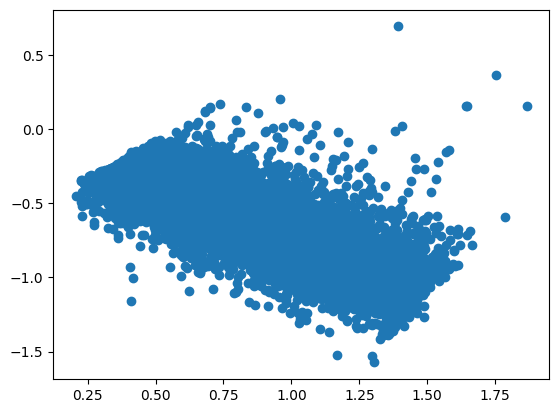

In [180]:
hey_X = X_train_transformed[y_train == 0]
hey_y = y_train[y_train == 0]

print(hey_X.shape)

plt.scatter(hey_X[:, 0], hey_X[:, 1])

In [49]:
import numpy as np

np.unique(y_train, return_counts=True)

(array([0, 2, 3], dtype=int64), array([70169, 66852,   543], dtype=int64))